# Notebook 2: Preliminary Missing Data
This notebook contains code used to clean the datasets that was ultimately scrapped in favor of better methods. It is here to document the various pitfalls and dead-ends we looked into in order to find the best way to clean the data. The better methods used that ultimately affected the final dataset used for modeling can be found in the Missing Data iPython Notebook.

In [7]:
# setting up environment
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import matplotlib as plt
import pickle

from collections import Counter

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
# load data
out = open('data/clean/risk.p', 'r')
risk = pickle.load(out)
out = open('data/clean/deaths_100k.p', 'r')
deaths = pickle.load(out)
out = open('data/clean/crops.p', 'r')
crops = pickle.load(out)
out = open('data/clean/meat.p', 'r')
meat = pickle.load(out)
out = open('data/clean/doctors.p', 'r')
doctors = pickle.load(out)
out = open('data/clean/beds.p', 'r')
beds = pickle.load(out)
out = open('data/clean/exer.p', 'r')
exer = pickle.load(out)

#### Check datasets for NaNs
Let's select only the dataset with NaNs to focus on.

In [9]:
# see if entire df contains NaNs
for df in [('risk', risk), ('doctors', doctors), ('beds', beds), ('exer', exer)]:
    if df[1].isnull().any().any():
        print df[0].upper(), 'CONTAINS NaNs'
        df[1].head(2)

DOCTORS CONTAINS NaNs


,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Country_corrected,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.034844,NaN,NaN,NaN,NaN,0.063428,NaN,NaN,NaN,NaN,...,0.146,0.145,0.175,0.194,0.234,0.225,0.266,NaN,NaN,NaN
Angola,0.067068,NaN,NaN,NaN,NaN,0.076062,NaN,NaN,NaN,NaN,...,NaN,NaN,0.166,NaN,NaN,NaN,NaN,NaN,NaN,NaN


BEDS CONTAINS NaNs


,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Country_corrected,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.170627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.42,0.42,0.4,0.4,NaN,0.5,NaN,NaN,NaN,NaN
Angola,2.061462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


EXER CONTAINS NaNs


,Percent
Country,
Afghanistan,NaN
Albania,NaN


In [10]:
for group in [('deaths', deaths), ('crops', crops), ('meat', meat)]:
    for df in group[1].values():
        if df.isnull().any().any():
            print group[0].upper(), 'CONTAINS NaNs'
            df.head(2)
            break

CROPS CONTAINS NaNs


,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Country,,,,,,,,,,,,,,,,,,,,,
Bangladesh,0.04,0.03,0.04,0.04,0.04,0.03,0.04,0.04,0.04,0.03,...,0.04,0.04,0.04,0.04,0.04,0.04,0.05,0.05,0.04,0.05
Brazil,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.09,0.06,0.10,...,0.22,0.22,0.22,0.22,0.22,0.21,0.21,0.21,0.21,0.21


MEAT CONTAINS NaNs


,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Country,,,,,,,,,,,,,,,,,,,,,
Canada,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
Chile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


The dataframes DOCTORS, BEDS, and EXER contain NaNs. The dataframe groups CROPS and MEAT contain NaNs. 

#### Counting complete columns
Let's see if we can select a subset of data from each of these objects that is complete and simply drop the rest. We know exercise is not complete, as we have only one year and we cannot ignore countries. We can check if any specific year has complete data for doctors and beds. For crops and meat, we can check if any crop or livestock items are individually complete, and then check each item for a specific year that's complete.

In [11]:
# check for complete years
def comp_yrs(df):
    answer = []
    for col in df:
        if df[col].isnull().any() == False:
            answer.append(col)
    return answer

In [12]:
# complete years in doctors, beds, exer
comp_count = 0
total_count = 0
for df in [('doctors', doctors), ('beds', beds), ('exer', exer)]:
    
    # increment total column count
    total_count += len(df[1].columns)
    result = comp_yrs(df[1])
    
    # print complete columns
    if result != []:
        for col in result:
            comp_count += 1
            print df[0], col

print 'Complete Columns in Doctors, Beds, Exercise: ', comp_count, '/', total_count

Complete Columns in Doctors, Beds, Exercise:  0 / 115


In [13]:
# complete dfs in crops, meat
comp_count = 0
total_count = 0
for group in [('crops', crops), ('meat', meat)]:
    for name, df in group[1].items():
        total_count += len(df.columns) 
        result = comp_yrs(df)
        if result != []:
            comp_count += len(result)
            print name, '\n', result, '\n'
            
print 'Complete Columns in Food Data: ', comp_count, '/', total_count

Ricebran Oil 
[1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011] 

Millet and products 
[1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011] 

Sesame seed 
[2006, 2007, 2008, 2009, 2010, 2011] 

Sugar non-centrifugal 
[1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011] 

Molasses 
[1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013] 

Sugar beet

#### Counting complete rows (countries)
The number of complete years is quite sparse throughout the datasets. 
Let's check how many complete rows there are. Perhaps dropping a few countries will make many more years complete.

In [14]:
nans_by_country = Counter()

In [15]:
# organize data into lists
dicts = [deaths, crops, meat]
dfs = [doctors, beds, exer]

In [16]:
# count up the number of NaNs for each country in the df
def count_nans(df, counter):
    for row in df.iterrows():
        # sum the number of NaNs in the row and add to the 
        # corresponding country's NaN count
        country = row[0]
        nan_count = sum(row[1].isnull())
        counter[country] += nan_count

In [17]:
# get total NaN values across all dataframes
for dictionary in dicts:
    # get to the dataframe
    for df in dictionary.values():
        count_nans(df, nans_by_country)
        
for df in dfs:
    count_nans(df, nans_by_country)

nans_by_country.most_common()[:20]

[('Serbia', 4806),
 ('Montenegro', 4614),
 ('Belgium', 4268),
 ('Slovakia', 3650),
 ('Ethiopia', 3601),
 ('Czech Republic', 3559),
 ('The former Yugoslav republic of Macedonia', 3547),
 ('Slovenia', 3523),
 ('Kazakhstan', 3481),
 ('Russian Federation', 3469),
 ('Latvia', 3459),
 ('Republic of Moldova', 3447),
 ('Croatia', 3447),
 ('Lithuania', 3431),
 ('Estonia', 3431),
 ('Ukraine', 3425),
 ('Bosnia and Herzegovina', 3404),
 ('Belarus', 3394),
 ('Armenia', 3356),
 ('Georgia', 3347)]


That's a lot of NaNs. Let's now look at NaNs per country for each dataset, so we can get some granularity on which NaNs are more important.

In [18]:
# get countries with most nans for crops
nans_crops = Counter()
for df in crops.values():
    count_nans(df, nans_crops)

nans_crops = nans_crops.most_common()[:20]
nans_crops

[('Serbia', 3290),
 ('Montenegro', 3243),
 ('Belgium', 2993),
 ('Ethiopia', 2592),
 ('Slovakia', 2516),
 ('Czech Republic', 2482),
 ('Slovenia', 2475),
 ('The former Yugoslav republic of Macedonia', 2442),
 ('Kazakhstan', 2442),
 ('Russian Federation', 2409),
 ('Croatia', 2409),
 ('Lithuania', 2376),
 ('Republic of Moldova', 2376),
 ('Estonia', 2376),
 ('Latvia', 2376),
 ('Bosnia and Herzegovina', 2343),
 ('Armenia', 2343),
 ('Ukraine', 2343),
 ('Belarus', 2343),
 ('Georgia', 2343)]

In [19]:
# get countries with most nans for meat
nans_meat = Counter()
for df in meat.values():
    count_nans(df, nans_meat)

nans_meat = nans_meat.most_common()[:20]
nans_meat

[('Serbia', 1410),
 ('Montenegro', 1269),
 ('Belgium', 1230),
 ('Ukraine', 1023),
 ('Latvia', 1023),
 ('Slovakia', 1020),
 ('Czech Republic', 1020),
 ('Lithuania', 990),
 ('Slovenia', 990),
 ('Bosnia and Herzegovina', 990),
 ('Russian Federation', 990),
 ('Belarus', 990),
 ('The former Yugoslav republic of Macedonia', 990),
 ('Croatia', 990),
 ('Estonia', 990),
 ('Kazakhstan', 990),
 ('Azerbaijan', 957),
 ('Armenia', 957),
 ('Republic of Moldova', 957),
 ('Georgia', 957)]

In [20]:
# get countries with most nans for doctors
nans_doctors = Counter()
count_nans(doctors, nans_doctors)
nans_doctors = nans_doctors.most_common()[:20]
nans_doctors

[('United States of America', 57),
 ('Yemen', 57),
 ('Iran (Islamic Republic of)', 57),
 ('Viet Nam', 57),
 ('Slovakia', 57),
 ('Bolivia (Plurinational State of)', 57),
 ('The former Yugoslav republic of Macedonia', 57),
 ('Republic of Moldova', 57),
 ('Bahamas', 57),
 ("Lao People's Democratic Republic", 57),
 ('Gambia', 57),
 ('United Republic of Tanzania', 57),
 ('Venezuela (Bolivarian Republic of)', 57),
 ('Republic of Korea', 57),
 ('Democratic Republic of the Congo', 57),
 ('United Kingdom of Great Britain and Northern Ireland', 57),
 ('Kyrgyzstan', 57),
 ('South Sudan', 57),
 ('Egypt', 57),
 ("Democratic People's Republic of Korea", 57)]

In [21]:
# get countries with most nans for beds
nans_beds = Counter()
count_nans(beds, nans_beds)
nans_beds = nans_beds.most_common()[:20]
nans_beds

[('United States of America', 57),
 ('Yemen', 57),
 ('Iran (Islamic Republic of)', 57),
 ('Viet Nam', 57),
 ('Slovakia', 57),
 ('Bolivia (Plurinational State of)', 57),
 ('The former Yugoslav republic of Macedonia', 57),
 ('Republic of Moldova', 57),
 ('Bahamas', 57),
 ("Lao People's Democratic Republic", 57),
 ('Gambia', 57),
 ('United Republic of Tanzania', 57),
 ('Venezuela (Bolivarian Republic of)', 57),
 ('Republic of Korea', 57),
 ('Democratic Republic of the Congo', 57),
 ('United Kingdom of Great Britain and Northern Ireland', 57),
 ('Kyrgyzstan', 57),
 ('South Sudan', 57),
 ('Egypt', 57),
 ("Democratic People's Republic of Korea", 57)]

In [22]:
# get countries with most nans for exercise
nans_exer = Counter()
count_nans(exer, nans_exer)
nans_exer = nans_exer.most_common()[:20]
nans_exer

[('Turkmenistan', 1),
 ('Oman', 1),
 ('Yemen', 1),
 ('Albania', 1),
 ('Azerbaijan', 1),
 ('Tajikistan', 1),
 ('Afghanistan', 1),
 ('Syrian Arab Republic', 1),
 ('Somalia', 1),
 ('Peru', 1),
 ('Cuba', 1),
 ('Montenegro', 1),
 ('Armenia', 1),
 ('Timor-Leste', 1),
 ('Bolivia (Plurinational State of)', 1),
 ('Bahrain', 1),
 ('Belarus', 1),
 ('Angola', 1),
 ('Brunei Darussalam', 1),
 ('Uganda', 1)]

#### Relationship between countries and years
Since exercise, beds, and doctors are really only supplemental data to this project, we should prioritize eliminating the NaNs appearing in the food data. We can varying numbers of countries with the most NaNs in the food data, then check how those drops increase the number of complete columns. In essence, we exchange the number of data points for more predictors. By trying out different numbers of countries to drop, we can find the tradeoff interaction between these two quantities.

In [23]:
cols_vs_dropped_crops = pd.DataFrame()
cols_vs_dropped_crops['complete columns'] = pd.Series()
# get countries with most nans for crops
crops_clean = crops.copy()
counter = 1
# for each country with the most NaNs
for country, count in nans_crops:
    # track the number of complete columns
    complete_columns = 0
    # for each dataframe in the dictionary
    for key, df in crops_clean.items():
        if country in df.index:
            df = df.drop(country)
            crops_clean[key] = df
        # count the number of complete columns
        complete_columns += sum(pd.isnull(df).sum() == 0)
    cols_vs_dropped_crops.loc[counter] = complete_columns
    counter += 1

In [24]:
cols_vs_dropped_crops

,complete columns
1,320.0
2,379.0
3,890.0
4,899.0
5,901.0
6,973.0
7,973.0
8,1004.0
9,1006.0
10,1037.0


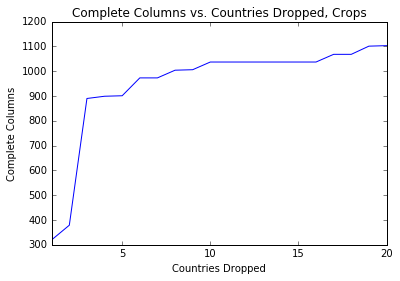

In [25]:
# plot complete columns vs. dropped countries for crops
ax = cols_vs_dropped_crops.plot(legend = False)
ax.set_xlabel("Countries Dropped")
ax.set_ylabel("Complete Columns")
ax.set_title("Complete Columns vs. Countries Dropped, Crops")

In [26]:
cols_vs_dropped_meat = pd.DataFrame()
cols_vs_dropped_meat['complete columns'] = pd.Series()
# get countries with most nans for crops
meat_clean = meat.copy()
counter = 1
# for each country with the most NaNs
for country, count in nans_meat:
    # track the number of complete columns
    complete_columns = 0
    # for each dataframe in the dictionary
    for key, df in meat_clean.items():
        if country in df.index:
            df = df.drop(country)
            meat_clean[key] = df
        # count the number of complete columns
        complete_columns += sum(pd.isnull(df).sum() == 0)
    cols_vs_dropped_meat.loc[counter] = complete_columns
    counter += 1

In [27]:
cols_vs_dropped_meat

,complete columns
1,122.0
2,122.0
3,332.0
4,332.0
5,363.0
6,363.0
7,364.0
8,364.0
9,364.0
10,364.0


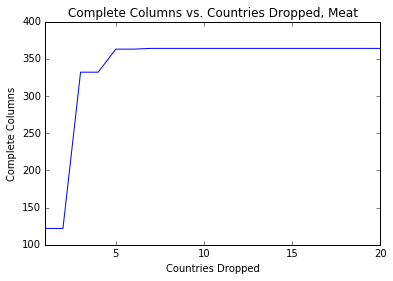

In [28]:
# plot complete columns vs. dropped countries for meat
ax = cols_vs_dropped_meat.plot(legend = False)
ax.set_xlabel("Countries Dropped")
ax.set_ylabel("Complete Columns")
ax.set_title("Complete Columns vs. Countries Dropped, Meat")

#### Identifying sparse years
We have a lot more years than we have countries. We should definitely consider dropping years with lots of NaNs as well. Let's see what the proportion is for each column.

In [29]:
# get nans by year for a df
def get_nan_by_year(df, counter):
    for col in df.columns:
        counter[col] += sum(df[col].isnull())

In [30]:
# get nans by year for a df with categories
def get_nan_by_year_categories(df, counter, category):
    for col in df.columns:
        counter[str(col) + ', ' + str(category)] += sum(df[col].isnull())

In [31]:
# get total NaN by year across all dataframes
nans_by_year = Counter()
for dictionary in dicts:
    # get to the dataframe
    for df in dictionary.values():
        get_nan_by_year(df, nans_by_year)
        
for df in dfs:
    get_nan_by_year(df, nans_by_year)

nans_by_year.most_common()[:20]

[(2013, 12560),
 (2012, 12487),
 (1962, 2918),
 (1963, 2918),
 (1964, 2918),
 (1961, 2917),
 (1967, 2916),
 (1968, 2916),
 (1969, 2916),
 (1966, 2914),
 (1974, 2910),
 (1972, 2909),
 (1973, 2907),
 (1971, 2906),
 (1976, 2905),
 (1978, 2905),
 (1977, 2903),
 (1979, 2895),
 (1983, 2874),
 (1982, 2865)]

In [32]:
# get countries with most nans for crops
nans_crops_by_year = Counter()
for crop, df in crops.items():
    get_nan_by_year_categories(df, nans_crops_by_year, crop)

nans_crops_by_year = nans_crops_by_year.most_common()
nans_crops_by_year

[('2012, Vegetables', 118),
 ('2012, Apples and products', 118),
 ('2013, Sweeteners, Other', 118),
 ('2013, Starchy Roots', 118),
 ('2012, Starchy Roots', 118),
 ('2013, Cocoa Beans and products', 118),
 ('2012, Spices', 118),
 ('2012, Oranges, Mandarines', 118),
 ('2012, Coffee and products', 118),
 ('2012, Tomatoes and products', 118),
 ('2013, Fruits - Excluding Wine', 118),
 ('2012, Cocoa Beans and products', 118),
 ('2013, Oranges, Mandarines', 118),
 ('2013, Sugar (Raw Equivalent)', 118),
 ('2012, Fruits - Excluding Wine', 118),
 ('2013, Coffee and products', 118),
 ('2012, Vegetable Oils', 118),
 ('2012, Potatoes and products', 118),
 ('2013, Rice (Milled Equivalent)', 118),
 ('2013, Sugar & Sweeteners', 118),
 ('2012, Stimulants', 118),
 ('2013, Vegetables, Other', 118),
 ('2013, Fruits, Other', 118),
 ('2012, Sweeteners, Other', 118),
 ('2013, Vegetable Oils', 118),
 ('2012, Sugar (Raw Equivalent)', 118),
 ('2012, Tea (including mate)', 118),
 ('2013, Apples and products', 11

In [33]:
# get countries with most nans for meat
nans_meat_by_year = Counter()
for meat, df in meat.items():
    get_nan_by_year_categories(df, nans_meat_by_year, meat)

nans_meat_by_year = nans_meat_by_year.most_common()
nans_meat_by_year

[('2012, Mutton & Goat Meat', 118),
 ('2012, Demersal Fish', 118),
 ('2012, Butter, Ghee', 118),
 ('2012, Animal fats', 118),
 ('2013, Freshwater Fish', 118),
 ('2013, Marine Fish, Other', 118),
 ('2013, Offals', 118),
 ('2013, Animal fats', 118),
 ('2012, Bovine Meat', 118),
 ('2013, Fish, Seafood', 118),
 ('2013, Poultry Meat', 118),
 ('2012, Offals, Edible', 118),
 ('2012, Meat', 118),
 ('2012, Milk - Excluding Butter', 118),
 ('2013, Bovine Meat', 118),
 ('2012, Marine Fish, Other', 118),
 ('2013, Milk - Excluding Butter', 118),
 ('2013, Meat', 118),
 ('2012, Fish, Seafood', 118),
 ('2013, Butter, Ghee', 118),
 ('2013, Mutton & Goat Meat', 118),
 ('2013, Meat, Other', 118),
 ('2012, Meat, Other', 118),
 ('2012, Offals', 118),
 ('2013, Offals, Edible', 118),
 ('2012, Pelagic Fish', 118),
 ('2013, Pelagic Fish', 118),
 ('2012, Poultry Meat', 118),
 ('2013, Eggs', 118),
 ('2013, Crustaceans', 118),
 ('2012, Crustaceans', 118),
 ('2012, Freshwater Fish', 118),
 ('2012, Eggs', 118),
 ('

In [34]:
# get countries with most nans for doctors
nans_doctors_by_year = Counter()
get_nan_by_year(doctors, nans_doctors_by_year)
nans_doctors_by_year = nans_doctors_by_year.most_common()[:20]
nans_doctors_by_year

[(2015, 172),
 (2016, 172),
 (2014, 171),
 (1962, 157),
 (1963, 157),
 (1964, 157),
 (1961, 156),
 (1967, 156),
 (1968, 156),
 (1969, 156),
 (1966, 154),
 (1974, 152),
 (1972, 150),
 (1976, 149),
 (1973, 148),
 (1978, 148),
 (1971, 146),
 (1977, 146),
 (2013, 145),
 (1979, 139)]

In [35]:
# get countries with most nans for beds
nans_beds_by_year = Counter()
get_nan_by_year(beds, nans_beds_by_year)
nans_beds_by_year = nans_beds_by_year.most_common()[:20]
nans_beds_by_year

[(2015, 172),
 (2016, 172),
 (2014, 171),
 (1961, 170),
 (1962, 170),
 (1963, 170),
 (1964, 170),
 (2013, 170),
 (1966, 169),
 (1967, 169),
 (1968, 169),
 (1969, 169),
 (1971, 169),
 (1965, 168),
 (1972, 168),
 (1973, 168),
 (1974, 167),
 (1977, 166),
 (1978, 166),
 (1976, 165)]

## Update: A New Approach
We cut short this endeavor here because we have decided to take on a new approach to eliminating NaNs. Rather than trying to preserve as many columns as possible, we want to average the values across the past couple of years. This should take care of many NaN values implicitly because as long as a single value appears in the time frame, it will calculate a mean. After calculating the average, we can drop countries and items as necessary to avoid large amounts of imputation. We will then impute with the global mean in order to minimize impact on the coefficients, as filling NaNs with any other value will skew the coefficients. This process is implemented in real time for each data set in the Baseline Model file.